# Binary morphologies

We will invent a binary log -- maybe you can load it from an LAS file with `welly`.

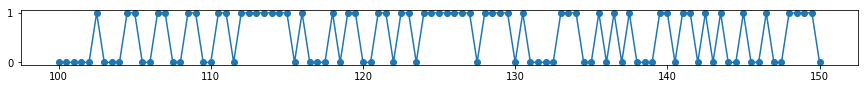

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

fake_depth = np.linspace(100, 150, 101)
fake_log = np.array([np.random.choice([0, 1]) for _ in fake_depth])

plt.figure(figsize=(15, 1))
plt.plot(fake_depth, fake_log, 'o-')

## Make a striplog

A `Striplog` is a sequence of `Interval` objects (representing a layer). Each `Interval` must contain a `Component` (representing the layer, perhaps a rock).

In [2]:
from striplog import Striplog, Component

In [3]:
comps = [
    Component({'pay': True}),
    Component({'pay': False})
]

In [4]:
s = Striplog.from_log(fake_log, cutoff=0.5, components=comps, basis=fake_depth)

In [5]:
s[-1].base.middle = 150.5 # Adjust the bottom thickness... not sure if this is a bug.

Each `Interval` in the striplog looks like:

In [6]:
s[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 102.5, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': True})]})

## Plot the intervals

To plot we need a legend, but we can generate a random one. This maps each `Component` to a colour (and a width and hatch, if you want).

We can generate a random legend:

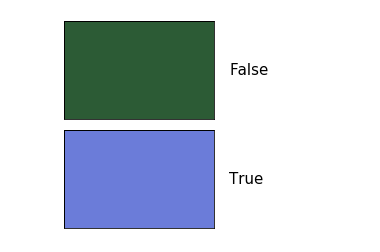

In [7]:
from striplog import Legend

legend = Legend.random(comps)
legend.get_decor(comps[-1]).width = 0.2
legend.plot()

Or we can make one with a bit more control:

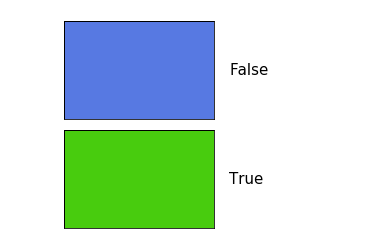

In [8]:
legend_csv = """colour,hatch,width,component pay
#48cc0e,None,1,True
#5779e2,None,0.2,False"""

legend = Legend.from_csv(text=legend_csv)

legend.plot()

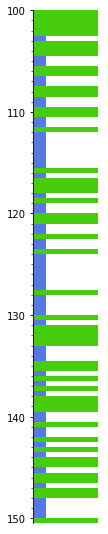

In [9]:
s.plot(legend=legend, aspect=5)

## Remove thin things

We can remove thin intervals:

In [10]:
pruned = s.prune(limit=1.0, keep_ends=True)

Now we can anneal the gaps:

In [11]:
annealed = pruned.anneal()

Then merge the adjacent intervals that are alike...

In [12]:
merged = annealed.merge_neighbours()  # Anneal works on a copy

We could have chained these commands:

    merged = s.prune(limit=1.0, keep_ends=True).anneal().merge_neighbours()

Let's plot all these steps, just for illustration:

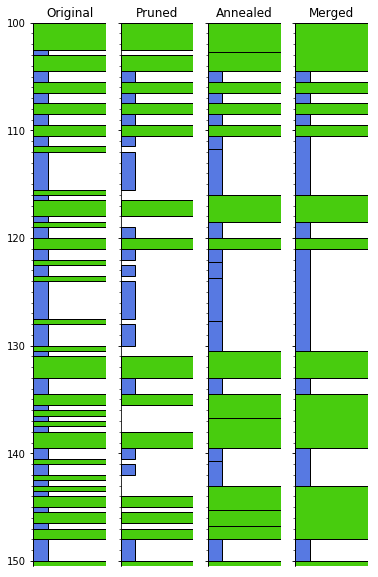

In [13]:
fig, axs = plt.subplots(ncols=4, figsize=(6, 10))

axs[0] = s.plot(legend=legend, ax=axs[0], lw=1, aspect=5)
axs[0].set_title('Original')
axs[1] = pruned.plot(legend=legend, ax=axs[1], lw=1, aspect=5)
axs[1].set_yticklabels([])
axs[1].set_title('Pruned')
axs[2] = annealed.plot(legend=legend, ax=axs[2], lw=1, aspect=5)
axs[2].set_yticklabels([])
axs[2].set_title('Annealed')
axs[3] = merged.plot(legend=legend, ax=axs[3], lw=1, aspect=5)
axs[3].set_yticklabels([])
axs[3].set_title('Merged')
plt.show()

## Dilate and erode

This would be a binary thing, at least for now. I made an issue for this: https://github.com/agile-geoscience/striplog/issues/95

You need to be on striplog v 0.8.1 at least for this to work.

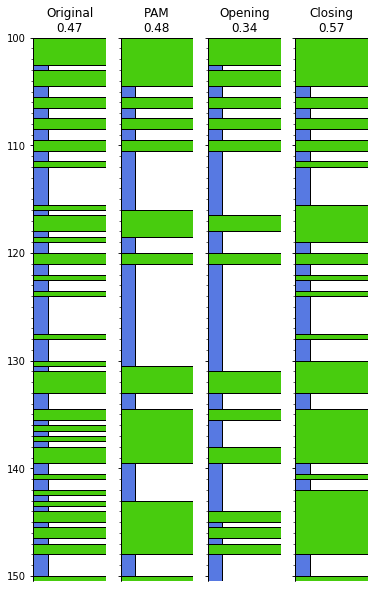

In [15]:
fig, axs = plt.subplots(ncols=4, figsize=(6, 10))

opening = s.binary_morphology('pay', 'opening', step=0.1, p=7)
closing = s.binary_morphology('pay', 'closing', step=0.1, p=7)

axs[0] = s.plot(legend=legend, ax=axs[0], lw=1, aspect=5)
ntg = s.net_to_gross('pay')
axs[0].set_title(f'Original\n{ntg:.2f}')
axs[1] = merged.plot(legend=legend, ax=axs[1], lw=1, aspect=5)
axs[1].set_yticklabels([])
ntg = merged.net_to_gross('pay')
axs[1].set_title(f'PAM\n{ntg:.2f}')  # Prune-anneal-merge
axs[2] = opening.plot(legend=legend, ax=axs[2], lw=1, aspect=5)
axs[2].set_yticklabels([])
ntg = opening.net_to_gross('pay')
axs[2].set_title(f'Opening\n{ntg:.2f}')
axs[3] = closing.plot(legend=legend, ax=axs[3], lw=1, aspect=5)
axs[3].set_yticklabels([])
ntg = closing.net_to_gross('pay')
axs[3].set_title(f'Closing\n{ntg:.2f}')
plt.show()

## Some statistics

We can get the unique components and their thicknesses:

In [22]:
s.unique

[(Component({'pay': False}), 27.0), (Component({'pay': True}), 23.5)]

We can get at the thickest (and thinnest, with `.thinnest()`) intervals:

In [23]:
s.thickest()

Interval({'top': Position({'middle': 124.0, 'units': 'm'}), 'base': Position({'middle': 127.5, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': False})]})

These functions optionally take an integer argument `n` specifying how many of the thickest or thinnest intervals you want to see. If `n` is greater than 1, a `Striplog` object is returned so you can see the positions of those items:

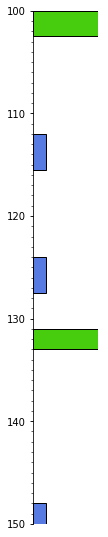

In [24]:
s.thickest(5).plot(legend=legend, lw=1, aspect=5)

## Bar plots and histograms

We can make a bar plot of the layers:

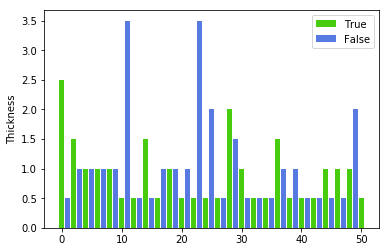

In [25]:
s.bar(legend=legend)

More interesting is to sort the thicknesses:

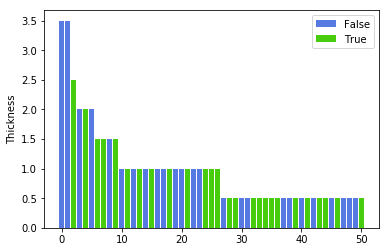

In [26]:
s.bar(legend=legend, sort=True)

Finally, we can make a thickness histogram of the various types of `component` present in the log.

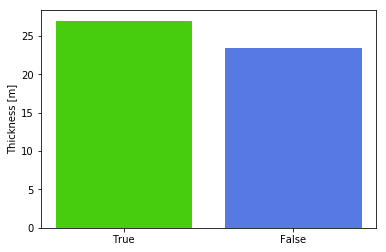

In [27]:
n, ents, ax = s.hist(legend=legend)

In [28]:
s

Striplog(51 Intervals, start=100.0, stop=150.5)

In [29]:
legend

Legend(Decor({'_colour': '#48cc0e', 'hatch': None, 'width': 1.0, 'component': Component({'pay': True})})
Decor({'_colour': '#5779e2', 'hatch': None, 'width': 0.2, 'component': Component({'pay': False})}))

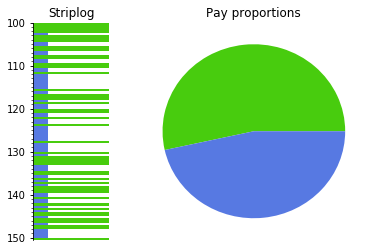

In [30]:
data = [c[1] for c in s.unique]
colors = [c['_colour'] for c in legend.table]

fig, axs = plt.subplots(ncols=2,
                        gridspec_kw={'width_ratios': [1, 3]})

axs[0] = s.plot(ax=axs[0], legend=legend)
axs[0].set_title("Striplog")

axs[1].pie(data, colors=colors)
axs[1].set_title("Pay proportions")

plt.show()